This notebook will: 
- Load a .stl file of a nanoparticle
- Snap the coordinates of that particle surface onto an nxnxn evenly spaced grid (essentially nearest neighbour)
- It will then make that surface watertight using a dilation algorithm
- The surface is then filled to create a volume
- This is then saved

In [449]:
# imports
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import scipy.interpolate
import trimesh
import copy
import cv2
import itertools
import pandas as pd

In [256]:
# load mesh into numpy-stl
fpath = r'C:\Users\grl31\Desktop\HK\LL1-downsample.stl'
particle_mesh = mesh.Mesh.from_file(fpath)

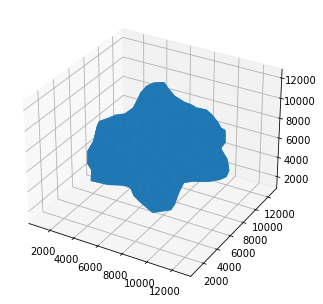

In [3]:
# visualise

# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(particle_mesh.vectors))

# Auto scale to the mesh size
scale = particle_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
plt.show()

In [257]:
# converty mesh into trimesh object
m = trimesh.Trimesh(**trimesh.triangles.to_kwargs(particle_mesh.vectors))

In [258]:
# check if you're happy with the number of vertices
coor = m.vertices
np.shape(coor)

(10871, 3)

In [385]:
# find boundaries of the dataset
xi = np.floor(np.min(particle_mesh.x))
xf = np.ceil(np.max(particle_mesh.x))
yi = np.floor(np.min(particle_mesh.y))
yf = np.ceil(np.max(particle_mesh.y))
zi = np.floor(np.min(particle_mesh.z))
zf = np.ceil(np.max(particle_mesh.z))

print('x:', xi,xf, 'y:', yi,yf, 'z:', zi,zf)

x: 1026.0 12666.0 y: 1210.0 12692.0 z: 2336.0 11181.0


In [387]:
def ndsnap_regular(points, *grid_axes):
    """ Snaps coordinates onto grid 
    returns new coordinates and their index in the grid 
    results in points being assigned to the grid point whose
    new x is closest to the old x, etc. for y and z.
    This is equivalent to the Manhatten/taxicab distance """
    snapped = []
    bests = []
    for i, ax in enumerate(grid_axes):                                   
        diff = ax[:, np.newaxis] - points[:, i] # difference between coordinate and grid value
        best = np.argmin(np.abs(diff), axis=0) # grid point with the smallest difference
        snapped.append(ax[best]) 
        bests.append(best)
    return np.array(snapped).T,np.array(bests).T

# Length of grid in voxels
n=300

# create regular grid (different formats for different uses)
grid = (np.linspace(xi, xf,n), np.linspace(yi, yf,n), np.linspace(zi, zf,n))
grid_x, grid_y, grid_z = np.mgrid[xi:xf:n, yi:yf:n, zi:zf:n]

# run snapping algorithm
_,coor_reg_ind = ndsnap_regular(coor, *grid)

Text(0.5, 1.0, 'Regridded surface coordinates')

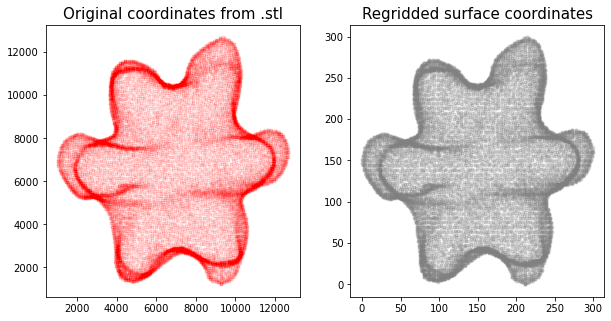

In [431]:
# show x,y coordinates of regridded coordinates
f,axs=plt.subplots(ncols=2,figsize=(10,5))
axs[0].scatter(particle_mesh.x,particle_mesh.y,color='r', vmin=-2, vmax= 2,alpha=0.01,marker='.')
axs[1].scatter(coor_reg_ind[:,0],coor_reg_ind[:,1],color='grey',alpha=0.2,marker='.')

axs[0].set_title('Original coordinates from .stl',fontsize=15)
axs[1].set_title('Regridded surface coordinates',fontsize=15)

In [389]:
# create nxnxn grid with values of 1 at regridded coordinates and 0 elsewhere
grid_surface_points = np.zeros((n,n,n))
for c in coor_reg_ind:
    grid_surface_points[c[0],c[1],c[2]] = 1

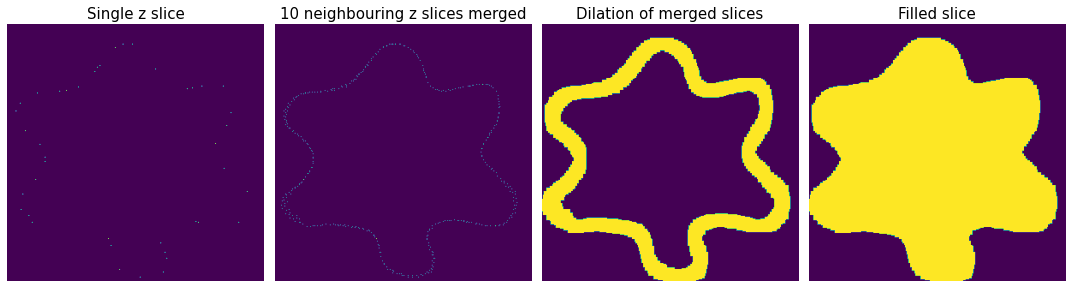

In [421]:
# demonstration of the next stage at a single slice

f,axs=plt.subplots(ncols=4,figsize=(15,5))

k_open=15 # size of kernel for dilation
z_merge = 10 # number of slices to pool together
kernel = np.ones((k_open,k_open),np.uint8)

z_zlice_single = grid_surface_points[:,:,int(n/2)]
z_slice_merged = np.sum(grid_surface_points[:,:,int(n/2):int(n/2)+z_merge],axis=2)
z_slice_merged_and_dilated = cv2.dilate(z_slice_merged,kernel,iterations = 1)
z_slice_merged_and_dilated = cv2.threshold(z_slice_merged_and_dilated, .5, 1, cv2.THRESH_BINARY)[1] # threshold at 1
z_slice_filled = scipy.ndimage.binary_fill_holes(z_slice_merged_and_dilated)

axs[0].imshow(z_zlice_single)
axs[0].set_title('Single z slice',fontsize=15)
axs[1].imshow(z_slice_merged)
axs[1].set_title('10 neighbouring z slices merged',fontsize=15)
axs[2].imshow(z_slice_merged_and_dilated)
axs[2].set_title('Dilation of merged slices',fontsize=15)
axs[3].imshow(z_slice_filled)
axs[3].set_title('Filled slice',fontsize=15)

for ax in axs:
    ax.axis('off')
    
plt.tight_layout()

In [433]:
# fill in the voxels within the surface using method shown above

def fill_in_volume(grid_surface_points,k_open=15,z_merge = 10):
    """ Takes gridded points on particle surface and fills in the volume within """
    kernel = np.ones((k_open,k_open),np.uint8)
    gridded_volume=[]
    for i in range(n-z_merge):
        z_slice=np.sum(grid_surface_points[:,:,i:i+z_merge],axis=2) # sum over a few z_slices 
        dilated = cv2.dilate(z_slice,kernel,iterations = 1) # dilate those pixels for a watertight boundary
        thresh = cv2.threshold(dilated, .5, 1, cv2.THRESH_BINARY)[1] # threshold at 1
        z_slice_filled = scipy.ndimage.binary_fill_holes(thresh) # fill in the hole(s)
        gridded_volume.append(z_slice_filled)

    gridded_volume = np.array(gridded_volume)
    
    return gridded_volume
    
gridded_volume = fill_in_volume(grid_surface_points)

Text(0.5, 1.0, 'Projection of extracted volume')

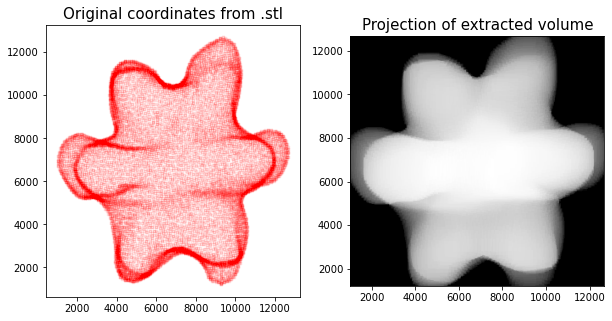

In [435]:
# check result
f,axs=plt.subplots(ncols=2,figsize=(10,5))

proj = np.average(gridded_volume.T,axis=2)

axs[0].scatter(particle_mesh.x,particle_mesh.y,color='r', vmin=-2, vmax= 2,alpha=0.01,marker='.')
axs[1].imshow(np.flipud(proj), cmap='Greys_r', extent=[xi,xf,yi,yf])

axs[0].set_title('Original coordinates from .stl',fontsize=15)
axs[1].set_title('Projection of extracted volume',fontsize=15)

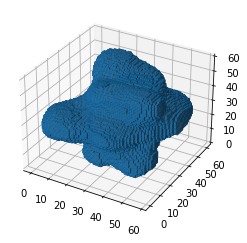

In [406]:
# show result in 3d

ax = plt.figure().add_subplot(projection='3d')
s=5 # stride through dataset (faster)
ax.voxels(gridded_volume[::s,::s,::s])

plt.show()

In [444]:
# get coordinates within the volume

# coordinates greater than 0 intensity
ix,iy,iz = np.where(gridded_volume>0)

# rescale ranges to match real space
xrange = xf-xi
yrange = yf-yi
zrange = zf-zi

xscale,yscale,zscale = xrange/xrange,yrange/xrange,zrange/xrange

ix,iy,iz = ix*xscale,iy*yscale,iz*zscale

In [474]:
xlength_nm = 0.92
voxel_vol = xscale*yscale*zscale*xlength_nm # nm^3
vol_tot = len(ix)*voxel_vol /(1000**3) # um^3
vol_tot

0.00702031250115201

In [459]:
# load coordinates into pandas dataframe
df = pd.DataFrame(data={'x':ix,'y':iy,'z':iz})

In [462]:
df

,x,y,z
0,0.0,32.552062,93.465204
1,0.0,32.552062,94.225084
2,0.0,32.552062,94.984964
3,0.0,32.552062,95.744843
4,0.0,32.552062,96.504723
...,...,...,...
10180263,289.0,238.715120,112.462197
10180264,289.0,238.715120,113.222077
10180265,289.0,238.715120,113.981956
10180266,289.0,238.715120,114.741836


In [460]:
# save output
df.to_csv('test.csv')

In [461]:
len(ix)

10180268